# Test parallel instabilities

###### Gary et al. Proton temperature anisotropy instabilities in the solar wind, JGR 1976

In [130]:
import numpy as np
import scipy.optimize
from py_vlasov.parallel_mode import parallel_em_wave_wrapper
from py_vlasov.util import real_imag, list_to_complex
import matplotlib.pyplot as plt
%matplotlib inline

## Firehose instabilities

In [131]:
k=0.1
betap = 1.
t_list=[1.,1.]
#a_list=[0.6,0.]
a_list=[0., 0.]
n_list=[1.,1.] 
q_list=[1.,-1.]
m_list=[1., 1/1836]
v_list=[0,0]

In [132]:
# firehose instabilities

f = lambda wrel: real_imag(parallel_em_wave_wrapper(wrel[0] + 1j * wrel[1], k, betap, t_list, \
                                                      a_list, n_list, q_list, \
                                                      m_list, v_list, method = 'pade', aol=1/5000, mode = 'r'))
guess = 0.1
freq = scipy.optimize.fsolve(f, real_imag(guess))
print(freq)

[  1.07277486e-01  -5.77446472e-09]


In [133]:
def simple_follow_fn(prev_result, prev_param_val, cur_param_val):
    """
    Follow a solution by using the previous result directly as a guess for \
    the new result.

    """
    return prev_result

In [134]:
def change_k(seed_freq, param, target_k, num_step, follow_k_fn=simple_follow_fn, step_method = 'log',  show_plot=True):
    """
    Follow the solution and incrementally change angles to the target_angle.
    
    Parameters
    ----------
    freq: w/proton_gyro_frequency
    param: list (k, theta, beta, te/tp, method, mratio, n, aol)
    wrel, k, betap, t_list, a_list, n_list, q_list,
                             m_list, v_list, method = 'pade', aol=1/5000, mode='r'
    target_angle: target propogation angle
    num_step: number of steps
    follow_beta_fn: how to follow from one beta to another beta
    show_plot: whether to show a plot of intermediate steps
    Return
    ------
    freq at the target angle
    """
    seed_k, betap, t_list, a_list, n_list, q_list, \
    m_list, v_list, method, aol, mode = param
    start = seed_k
    stop = target_k
    if step_method == 'log':
        k_list = np.logspace(np.log10(start), np.log10(stop), num_step, endpoint=True)
    else:
        k_list = np.linspace(start, stop, num_step, endpoint=True)
    result = [seed_freq]
    for i in list(range(num_step))[1:]:
        k = k_list[i]
        prev_k = k_list[i-1]
        prev_result = result[-1]
        guess = follow_k_fn(prev_result, prev_k, k)
        f = lambda wrel: real_imag(parallel_em_wave_wrapper(wrel[0] + 1j * wrel[1], k, betap, t_list, \
                                                            a_list, n_list, q_list, \
                                                            m_list, v_list, method = method, aol=aol, mode = mode))
        freq = scipy.optimize.fsolve(f, real_imag(guess))
        result += [list_to_complex(freq)]

    if show_plot:
        plt.plot(k_list, np.real(result), 'o-', markersize= 2)
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel(r'$k\rho_p$')
        plt.ylabel(r'$\omega/\Omega_{ci}$')
        plt.title(r'Change $k\rho_p$ from {0} to {1}'.format(seed_k, target_k))
        plt.show()
    return k_list, result


### Without anisotropy

In [147]:
seed_freq = 1.07277486e-01  - 5.77446472e-09j
target_k = 1.0
num_step = 100
step_method = 'linear'
#------------------------------
betap = 1.
t_list=[1.,1.]
#a_list=[0,0.]
a_list=[0.,0.]
n_list=[1.,1.] 
q_list=[1.,-1.]
m_list=[1., 1/1836]
v_list=[0,0]
method = 'numpy'
aol = 1/5000.
mode = 'r'
param = [k, betap, t_list, a_list, n_list, q_list, m_list, v_list, method, aol, mode]

In [148]:
i_k_list, i_w_list = change_k(seed_freq, param, target_k, num_step, show_plot=False);
i_w_list = np.array(i_w_list)

### with anisotropy

In [149]:
seed_freq = 9.23496910e-02 + 3.52557188e-08j
target_k = 1.0
num_step = 100
step_method = 'linear'
#------------------------------
betap = 1.
t_list=[1.,1.]
#a_list=[0,0.]
a_list=[0.6,0.]
n_list=[1.,1.] 
q_list=[1.,-1.]
m_list=[1., 1/1836]
v_list=[0,0]
method = 'numpy'
aol = 1/5000.
mode = 'r'
param = [k, betap, t_list, a_list, n_list, q_list, m_list, v_list, method, aol, mode]

In [150]:
a_k_list, a_w_list = change_k(seed_freq, param, target_k, num_step, show_plot=False);
a_w_list = np.array(a_w_list)

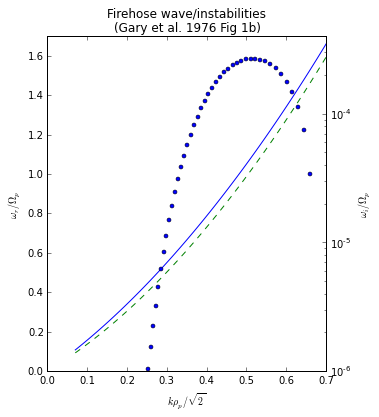

In [151]:
fig, ax1 = plt.subplots(figsize=[5,6])
ax1.plot(i_k_list/np.sqrt(2), np.real(i_w_list))
ax1.plot(a_k_list/np.sqrt(2), np.real(a_w_list), '--')
ax1.set_ylim([0,1.7])
ax1.set_xlim([0, 0.7])
ax1.set_xlabel(r'$k\rho_p/\sqrt{2}$')
ax1.set_ylabel(r'$\omega_r/\Omega_p$')
ax2 = ax1.twinx()
ax2.plot(a_k_list/np.sqrt(2), np.imag(a_w_list), 'o', markersize=4)
ax2.set_ylim([1e-6, 4e-4])
ax1.set_xlim([0, 0.7])
ax2.set_yscale('log')
ax2.set_ylabel(r'$\omega_i/\Omega_p$')
ax1.set_title('Firehose wave/instabilities \n(Gary et al. 1976 Fig 1b)')

In [152]:
fig.savefig('fh_instabilities_1.png', dpi=300)

In [33]:
# inspect object method

[method for method in dir(ax1) if callable(getattr(ax1, method))];

## ion cyclotron instabilities

In [112]:
k=0.1
betap = 1.
t_list=[1.,1.]
a_list=[-1.5,0.]
#a_list=[0., 0.]
n_list=[1.,1.] 
q_list=[1.,-1.]
m_list=[1., 1/1836]
v_list=[0,0]

In [114]:
f = lambda wrel: real_imag(parallel_em_wave_wrapper(wrel[0] + 1j * wrel[1], k, betap, t_list, \
                                                      a_list, n_list, q_list, \
                                                      m_list, v_list, method = 'numpy', aol=1/5000, mode = 'l'))
guess = .1
freq = scipy.optimize.fsolve(f, real_imag(guess))
print(freq)

[  1.28927702e-01   7.78764338e-32]


### Isotropic

In [144]:
seed_freq =  9.22162946e-02  + 1.10583914e-08j
target_k = 1.0
num_step = 50
step_method = 'linear'
#------------------------------
betap = 1.
t_list=[1.,1.]
#a_list=[0,0.]
a_list=[0.,0.]
n_list=[1.,1.] 
q_list=[1.,-1.]
m_list=[1., 1/1836]
v_list=[0,0]
method = 'numpy'
aol = 1/5000.
mode = 'l'
param = [k, betap, t_list, a_list, n_list, q_list, m_list, v_list, method, aol, mode]

In [145]:
i_k_list, i_w_list = change_k(seed_freq, param, target_k, num_step, show_plot=False);
i_w_list = np.array(i_w_list)

### anisotropic

In [146]:
seed_freq =  1.28927702e-01 + 7.78764338e-32
target_k = 1.0
num_step = 50
step_method = 'linear'
#------------------------------
betap = 1.
t_list=[1.,1.]
a_list=[-1.5,0.]
#a_list=[0.,0.]
n_list=[1.,1.] 
q_list=[1.,-1.]
m_list=[1., 1/1836]
v_list=[0,0]
method = 'numpy'
aol = 1/5000.
mode = 'l'
param = [k, betap, t_list, a_list, n_list, q_list, m_list, v_list, method, aol, mode]

In [143]:
a_k_list, a_w_list = change_k(seed_freq, param, target_k, num_step, show_plot=False);
a_w_list = np.array(a_w_list)

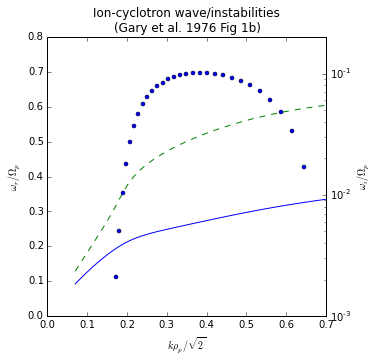

In [129]:
fig, ax1 = plt.subplots(figsize=[5,5])
ax1.plot(i_k_list/np.sqrt(2), np.real(i_w_list))
ax1.plot(a_k_list/np.sqrt(2), np.real(a_w_list), '--')
ax1.set_ylim([0,0.8])
ax1.set_xlim([0, 0.7])
ax1.set_xlabel(r'$k\rho_p/\sqrt{2}$')
ax1.set_ylabel(r'$\omega_r/\Omega_p$')
ax2 = ax1.twinx()
ax2.plot(a_k_list/np.sqrt(2), np.imag(a_w_list), 'o', markersize=4)
ax2.set_ylim([1e-3, 2e-1])
ax1.set_xlim([0, 0.7])
ax2.set_yscale('log')
ax2.set_ylabel(r'$\omega_i/\Omega_p$')
ax1.set_title('Ion-cyclotron wave/instabilities \n(Gary et al. 1976 Fig 1b)')

In [141]:
fig.savefig('ic_instabilities_1.png', dpi=300)